## 1.基础篇

### 关键点检测介绍

In [ ]:
# 环境导入
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import paddle

paddle.set_device('gpu') # 设置为GPU

import warnings 
warnings.filterwarnings('ignore') # 忽略 warning

## 2. 数据准备

### 2.1 下载数据集
本次实验所采用的数据集来源为github的[开源项目](https://github.com/udacity/P1_Facial_Keypoints)

目前该数据集已上传到 AI Studio [人脸关键点识别](https://aistudio.baidu.com/aistudio/datasetdetail/69065)，加载后可以直接使用下面的命令解压。

In [4]:
# !unzip data/data69065/data.zip 

解压后的数据集结构为
```
data/
|—— test
|   |—— Abdel_Aziz_Al-Hakim_00.jpg
    ... ...
|—— test_frames_keypoints.csv
|—— training
|   |—— Abdullah_Gul_10.jpg
    ... ...
|—— training_frames_keypoints.csv
```
其中，``training`` 和 ``test`` 文件夹分别存放训练集和测试集。``training_frames_keypoints.csv`` 和 ``test_frames_keypoints.csv`` 存放着训练集和测试集的标签。接下来，我们先来观察一下 ``training_frames_keypoints.csv`` 文件，看一下训练集的标签是如何定义的。

In [8]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv') # 读取数据集
print('Number of images: ', key_pts_frame.shape[0]) # 输出数据集大小
print(key_pts_frame.head(5)) # 看前五条数据
print('**'*50)
key_pts_frame.tail(5) # 看后五条数据

Number of images:  3462
                   Unnamed: 0     0     1     2      3     4      5     6  \
0           Luis_Fonsi_21.jpg  45.0  98.0  47.0  106.0  49.0  110.0  53.0   
1       Lincoln_Chafee_52.jpg  41.0  83.0  43.0   91.0  45.0  100.0  47.0   
2       Valerie_Harper_30.jpg  56.0  69.0  56.0   77.0  56.0   86.0  56.0   
3         Angelo_Reyes_22.jpg  61.0  80.0  58.0   95.0  58.0  108.0  58.0   
4  Kristen_Breitweiser_11.jpg  58.0  94.0  58.0  104.0  60.0  113.0  62.0   

       7     8  ...   126    127    128    129   130    131   132    133  \
0  119.0  56.0  ...  83.0  119.0   90.0  117.0  83.0  119.0  81.0  122.0   
1  108.0  51.0  ...  85.0  122.0   94.0  120.0  85.0  122.0  83.0  122.0   
2   94.0  58.0  ...  79.0  105.0   86.0  108.0  77.0  105.0  75.0  105.0   
3  120.0  58.0  ...  98.0  136.0  107.0  139.0  95.0  139.0  91.0  139.0   
4  121.0  67.0  ...  92.0  117.0  103.0  118.0  92.0  120.0  88.0  122.0   

    134    135  
0  77.0  122.0  
1  79.0  122.0  
2  73

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0
3461,Rocco_Buttiglione_42.jpg,93.0,134.0,93.0,147.0,95.0,157.0,100.0,167.0,105.0,...,167.0,174.0,167.0,168.0,167.0,174.0,164.0,173.0,159.0,173.0


上表中每一行都代表一条数据，其中，第一列是图片的文件名，之后从第0列到第135列，就是该图的关键点信息。因为每个关键点可以用两个坐标表示，所以 136/2 = 68，就可以看出这个数据集为68点人脸关键点数据集。

Tips1: 目前常用的人脸关键点标注，有如下点数的标注
- 5点
- 21点
- 68点
- 98点

Tips2：本次所采用的68标注，标注顺序如下：

![](https://ai-studio-static-online.cdn.bcebos.com/a9161a11b91b468497e9fbbf565a0a638ace47b2a6c54748a7bd2e497ea0727f)

In [9]:
# 计算标签的均值和标准差，用于标签的归一化
key_pts_values = key_pts_frame.values[:,1:] # 取出标签信息
data_mean = key_pts_values.mean() # 计算均值
data_std = key_pts_values.std()   # 计算标准差
data_num = len(key_pts_values)
print('数据量：', data_num)
print('标签的均值为:', data_mean)
print('标签的标准差为:', data_std)

数据量： 3462
标签的均值为: 104.4724870017331
标签的标准差为: 43.17302271754281


### 2.2 查看数据

In [43]:
def show_keypoints(image, key_pts, axis):
    """
    Args:
        image: 图像信息
        key_pts: 关键点信息，
    展示图片和关键点信息
    """
    axis.imshow(image.astype('uint8'))  # 展示图片信息
    for i in range(len(key_pts)//2,):
        axis.scatter(key_pts[i*2], key_pts[i*2+1], s=20, marker='.', c='b') # 展示关键点信息

(136,)


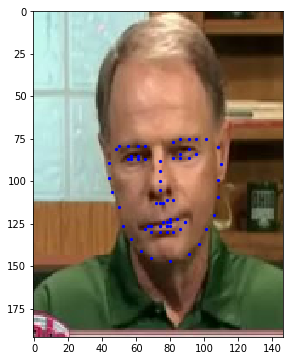

In [44]:
# 展示单条数据

n = 154 # n为数据在表格中的索引 
image_name = key_pts_frame.iloc[n, 0] # 获取图像名称
key_pts = key_pts_frame.iloc[n, 1:].values # 将图像label格式转为numpy.array的格式
key_pts = key_pts.astype('float').reshape(-1) # 获取图像关键点信息
print(key_pts.shape)
plt.figure(figsize=(6, 6)) # 展示的图像大小
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts, plt) # 展示图像与关键点信息
plt.show() # 展示图像

#### subplots_adjust
- 使用subplots_adjust一般会传入6个参数，我们分别用A，B，C，D，E，F表示。然后我们对图框建立坐标系，将坐标轴原点定在左下角点，并将整个图框归一化，即横纵坐标都是0到1之间。从下图中可以看出前四个参数所代表的距离
![](https://ai-studio-static-online.cdn.bcebos.com/4c474ea28dd4428f9e46038f815c9fb59d78fd445dcb410eb78b815261e3e430)

- A,B可以理解是图像左下角点的坐标，C,D可以理解为图像右上角点的坐标，至于E,F则是控制子图之间的距离。注意这些值都是0到1之间的值，代表百分比。

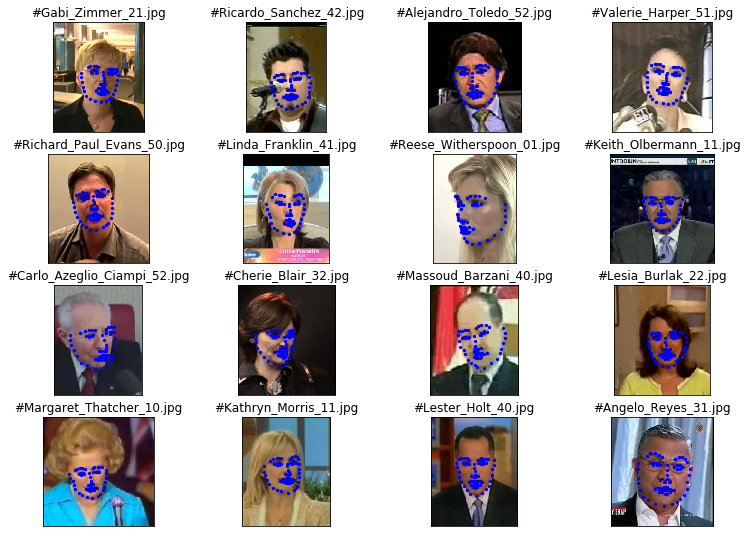

In [46]:
# 随机展示16条数据
fig = plt.figure(figsize=(10, 7))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

for i in range(16):
    idx = np.random.randint(data_num)
    image_name = key_pts_frame.iloc[idx, 0]
    key_pts = key_pts_frame.iloc[idx, 1:].values  #将图像label格式转为numpy.array的格式
    key_pts = key_pts.astype('float32').reshape(-1)

    # 设置图片打印信息
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    axis.set_title('#{}'.format(image_name))
    
    # 输出图片
    
    show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts, axis)


### 2.3 数据集定义
飞桨（PaddlePaddle）数据集加载方案是统一使用Dataset（数据集定义） + DataLoader（多进程数据集加载）。

首先我们先进行数据集的定义，数据集定义主要是实现一个新的Dataset类，继承父类paddle.io.Dataset，并实现父类中以下两个抽象方法，__getitem__和__len__：

使用飞桨框架高层API的 ``paddle.io.Dataset`` 自定义数据集类，具体可以参考官网文档 [自定义数据集](https://www.paddlepaddle.org.cn/documentation/docs/zh/guides/02_paddle2.0_develop/02_data_load_cn.html#id3)。

In [ ]:
# drop 和 iloc
data_path = 'data/training_frames_keypoints.csv'
key_pts_frame = pd.read_csv(data_path)
label1 = key_pts_frame.drop('Unnamed: 0', axis=1)
label = key_pts_frame.iloc[:, 1:]
label == label1
# key_pts_frame[:]

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3458,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3459,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3460,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [200]:
image = cv2.imread(os.path.join(Root_dir_train, 'Chuck_Hagel_21.jpg'))

In [197]:
Root_dir_train = 'data/training/' 
image = mpimg.imread(os.path.join(Root_dir_train, 'Chuck_Hagel_21.jpg'))

In [228]:
from paddle.io import Dataset
# from paddle.vision import transforms
Train_Dir = 'data/training_frames_keypoints.csv'
Test_Dir = 'data/test_frames_keypoints.csv'
Root_dir_train = 'data/training/' 
Root_dir_val = 'data/test/'

class FaceDataset(Dataset):
    # 人脸关键点检测 Dataset
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, csv_file, root_dir, mode='train', transforms=None):
        """
        步骤二：实现构造函数，定义数据集大小
        Args:
            mode('train', 'val', 'test'): 训练模式
            csv_file (string): 带标注的csv文件路径
            root_dir (string): 图片存储的文件夹路径
            transform (callable, optional): 应用于图像上的数据处理方法
        """
        self.mode = mode
        assert self.mode in ['train', 'val', 'test'], \
            "mode should be 'train' or 'test', but got {}".format(self.mode)
        self.key_pts_frame = pd.read_csv(csv_file)
        # 清洗数据, 数据集中有很多样本只标注了部分关键点, 这里有两种策略
        # 第一种, 将未标注的位置从上一个样本对应的关键点复制过来
        # self.key_pts_frame.fillna(method = 'ffill',inplace = True)
        # 第二种, 将包含有未标注的样本从数据集中移除
        self.key_pts_frame.dropna(how="any", inplace=True)  
        # self.data_label_all = self.key_pts_frame.drop('Image', axis = 1)

        self.root_dir = root_dir # 获取图片文件夹路径
        self.transform = transforms # 获取 transform 方法

    def __getitem__(self, idx):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        # 实现 __getitem__
        image_name = self.key_pts_frame.iloc[idx,0]
        image = mpimg.imread(os.path.join(self.root_dir, image_name))
        
        key_pts = self.key_pts_frame.iloc[idx,1:].values.astype('float32').reshape(-1)
        if self.transform is not None:
            image, key_pts = self.transform([image,key_pts])
        return image, key_pts
    def __len__(self):
        return len(self.key_pts_frame)


In [229]:
faceData = FaceDataset(csv_file=Train_Dir, root_dir=Root_dir_train, mode='train')

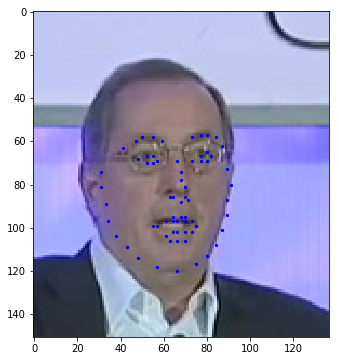

In [234]:
# 可视化
img, key_pts = faceData[10]
plt.figure(figsize=(6, 6))
show_keypoints(img, key_pts, plt)
plt.show()

数据集大小为:  3462
0 (267, 211, 4) (136,)
1 (240, 282, 4) (136,)
2 (288, 237, 4) (136,)


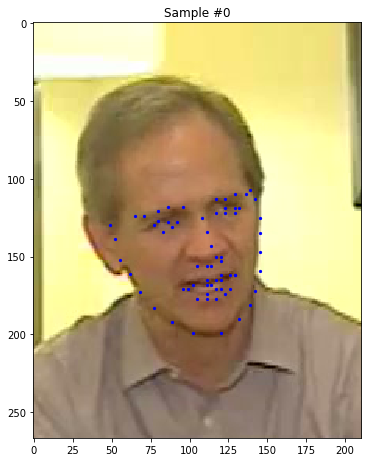

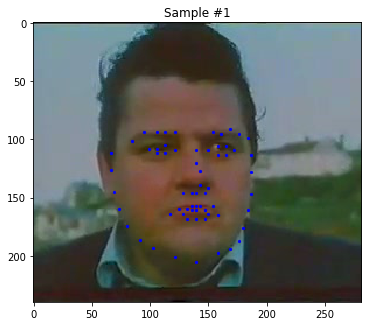

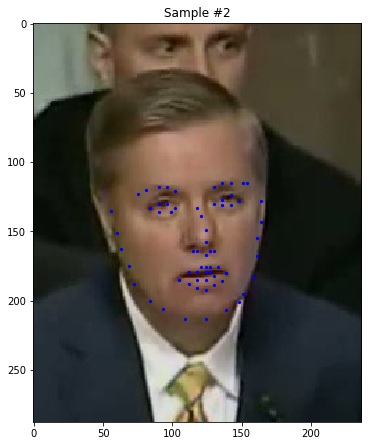

In [235]:
# 构建一个数据集类
face_dataset = FaceDataset(csv_file=Train_Dir, root_dir=Root_dir_train, mode='train')

# 输出数据集大小
print('数据集大小为: ', len(face_dataset))
# 根据 face_dataset 可视化数据集
num_to_display = 3

for i in range(num_to_display):
    
    # 定义图片大小
    fig = plt.figure(figsize=(20,10))
    
    # 随机选择图片
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # 输出图片大小和关键点的数量
    print(i, sample[0].shape, sample[1].shape)

    # 设置图片打印信息
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # 输出图片
    show_keypoints(sample[0], sample[1], plt)

上述代码虽然完成了数据集的定义，但是还有一些问题，如：
- 每张图像的大小不一样，图像大小需要统一以适配网络输入要求
- 图像格式需要适配模型的格式输入要求
- 数据量比较小，没有进行数据增强

这些问题都会影响模型最终的性能，所以需要对数据进行预处理。

### 2.4 Transforms

对图像进行预处理，包括灰度化、归一化、重新设置尺寸、随机裁剪，修改通道格式等等，以满足数据要求；每一类的功能如下：
- 灰度化：丢弃颜色信息，保留图像边缘信息；识别算法对于颜色的依赖性不强，加上颜色后鲁棒性会下降，而且灰度化图像维度下降（3->1），保留梯度的同时会加快计算。
- 归一化：加快收敛
- 重新设置尺寸：数据增强
- 随机裁剪：数据增强
- 修改通道格式：改为模型需要的结构

In [158]:
# 标准化定义 Transform 方法

import paddle.vision.transforms.functional as F

class GrayNormalize(object):
    # 将图片变为灰度图，并将其放缩到[0,1]
    # 将 label 放缩到[-1, 1]之间

    def __call__(self, data):
        image = data[0]
        key_pts = data[1]

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # 灰度化图片，输出通道为3
        gray_scale = paddle.vision.transforms.Grayscale(num_output_channels=3)
        image_copy = gray_scale(image_copy)

        # 将图片值放缩到[0,1]
        image_copy = image_copy / 255.0

        # 将label 放缩到[-1, 1]
        mean = data_mean
        std = data_std
        key_pts_copy = (key_pts_copy - mean) / std

        return image_copy, key_pts_copy

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


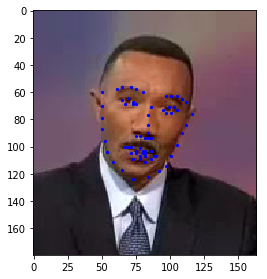

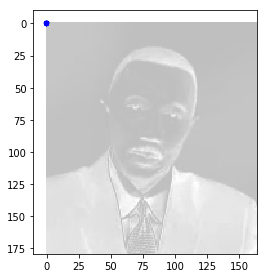

In [238]:
#  test GrayNormlize
idx = np.random.randint(data_num)
plt.figure(figsize=(4,8))
img, key_pts = face_dataset[idx]
show_keypoints(img, key_pts, plt)
gra = GrayNormalize()
img_g, key_pts_g = gra([img, key_pts])
plt.figure(figsize=(4,8))
show_keypoints(img_g, key_pts_g, plt)
print(type(img_g))
print(type(key_pts_g))

In [142]:
import cv2
class Resize(object):
    # 将输入图像调整为指定大小

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            output_size = (output_size, output_size)
        self.output_size = output_size
    def __call__(self, data):
        image = data[0]    # 获取图片
        key_pts = data[1]  # 获取标签

        image_copy = np.copy(image)      
        key_pts_copy = np.copy(key_pts)
        h, w = image_copy.shape[:2]

        
        # 短边补齐
        # diff = int((h - w) / 2)
        # if diff > 0:
        #     image_copy = cv2.copyMakeBorder(image_copy, 0, 0, diff, diff, cv2.BORDER_REFLECT_101)
        # else :
        #     image_copy = cv2.copyMakeBorder(image_copy, diff, diff, 0, 0, cv2.BORDER_REFLECT_101)

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        image_copy = F.resize(image_copy, self.output_size)
        # 对每一个point点修改
        key_pts_copy[::2] = key_pts_copy[::2] * new_w / w
        key_pts_copy[1::2] = key_pts_copy[1::2] * new_h / h

        return image_copy, key_pts_copy
        



(187, 127, 4)
(224, 224, 4)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


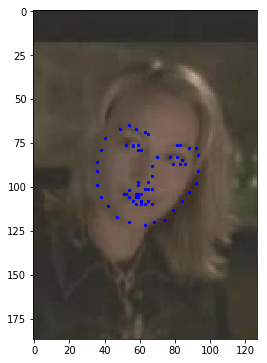

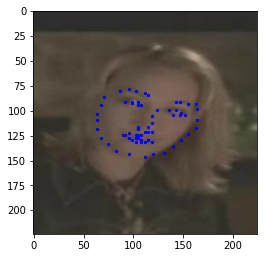

In [240]:
# test Resize
idx = np.random.randint(data_num)
plt.figure(figsize=(4,8))
img, key_pts = face_dataset[idx]
print(img.shape)
show_keypoints(img, key_pts, plt)
resize = Resize(224)
img_r, key_pts_r = resize([img, key_pts])
print(img_r.shape)
plt.figure(figsize=(4,8))
show_keypoints(img_r, key_pts_r, plt)
print(type(img_r))
print(type(key_pts_r))

In [149]:
class RandomCrop(object):
    # 随机位置裁剪输入的图像
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, data):
        image = data[0]    # 获取图片
        key_pts = data[1]  # 获取标签

        image_copy = np.copy(image)      
        key_pts_copy = np.copy(key_pts)
        h, w = image_copy.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image_copy = image_copy[top : top + new_h, left: left + new_w]

        key_pts_copy[::2] = key_pts_copy[::2] - left
        key_pts_copy[1::2] = key_pts_copy[1::2] - top

        return image_copy, key_pts_copy
        

(320, 339, 4)
(224, 224, 4)
(150, 150, 4)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


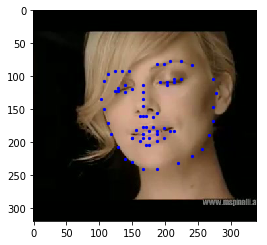

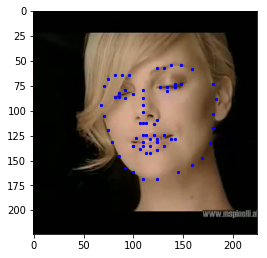

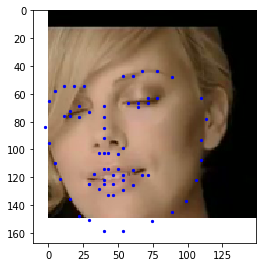

In [241]:
# test RandomCrop
idx = np.random.randint(data_num)
plt.figure(figsize=(4,8))
img, key_pts = face_dataset[idx]
print(img.shape)
show_keypoints(img, key_pts, plt)
resize = Resize(224)
randomCrop = RandomCrop(150)
img_r, key_pts_r = resize([img, key_pts])
img_r2, key_pts_r2 = randomCrop([img_r, key_pts_r])
print(img_r.shape)
plt.figure(figsize=(4,8))
show_keypoints(img_r, key_pts_r, plt)
print(img_r2.shape)
plt.figure(figsize=(4,8))
show_keypoints(img_r2, key_pts_r2, plt)
print(type(img_r2))
print(type(key_pts_r2))

In [168]:
class ToCHW(object):
    # 将图像的格式由HWC改为CHW

    """
    图像预处理工具，用于将图像进行升维(96, 96) => (96, 96, 3)，
    并对图像的维度进行转换从HWC变为CHW
    """
    def __init__(self, fmt):
        self.format = fmt

    def __call__(self, data):
        img = data[0]
        key_pts = data[1]
        if len(img.shape) == 2:
            img = np.expand_dims(img, axis=2)
        img =  img.transpose(self.format)

        if img.shape[0] == 1:
            img = np.repeat(img, 3, axis=0)
        return img, key_pts

In [242]:
idx = np.random.randint(data_num)
img, key_pts = face_dataset[idx]
print(img.shape)
tochw = ToCHW(fmt=(2,0,1))
img_t, key_pts_t = tochw([img,key_pts])
print(img_t.shape)
print(type(img_t))
print(type(key_pts_t))

(198, 197, 4)
(4, 198, 197)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### 2.5 使用数据预处理的方式完成数据定义

让我们将 ``Resize、RandomCrop、GrayNormalize、ToCHW`` 应用于新的数据集

In [222]:
from paddle.vision.transforms import Compose

'''
    Compose
    class paddle.vision.transforms.Compose(transforms)[源代码]
    将用于数据集预处理的接口以列表的方式进行组合。

    参数
    transforms (list) - 用于组合的数据预处理接口实例列表。

    返回
    一个可调用的Compose对象，它将依次调用每个给定的 transforms。
'''
data_transform = Compose([Resize(256), RandomCrop(224), GrayNormalize(), ToCHW(fmt=(2,0,1))])

# create the transformed dataset
train_dataset = FaceDataset(csv_file='data/training_frames_keypoints.csv',
                                       root_dir='data/training/',
                                       mode='train',
                                       transforms=data_transform)
print('Number of train dataset images: ', len(train_dataset))

for i in range(10):
    sample = train_dataset[i]
    print(i, sample[0].shape, sample[1].shape)

val_dataset = FaceDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             mode='val',
                                             transforms=data_transform)

print('Number of test dataset images: ', len(val_dataset))

Number of train dataset images:  3462
0 (3, 224, 224) (136,)
1 (3, 224, 224) (136,)
2 (3, 224, 224) (136,)
3 (3, 224, 224) (136,)
4 (3, 224, 224) (136,)
5 (3, 224, 224) (136,)
6 (3, 224, 224) (136,)
7 (3, 224, 224) (136,)
8 (3, 224, 224) (136,)
9 (3, 224, 224) (136,)
Number of test dataset images:  770


In [223]:
len(train_dataset[1][0])

3

##  3、模型组建

### 3.1 组网可以很简单

根据前文的分析可知，人脸关键点检测和分类，可以使用同样的网络结构，如LeNet、Resnet50等完成特征的提取，只是在原来的基础上，需要修改模型的最后部分，将输出调整为 人脸关键点的数量*2，即每个人脸关键点的横坐标与纵坐标，就可以完成人脸关键点检测任务了，具体可以见下面的代码，也可以参考官网案例:[人脸关键点检测](https://www.paddlepaddle.org.cn/documentation/docs/zh/tutorial/cv_case/landmark_detection/landmark_detection.html)

网络结构如下：
![](https://ai-studio-static-online.cdn.bcebos.com/acb845e2651647628e71462e356045dd4fdbdfe570364fe99224af20d39a4576)

In [244]:
import paddle.nn as nn
from paddle.vision.models import resnet50
class SimpleNet(nn.Layer):
    
    def __init__(self, key_pts:int):

        super(SimpleNet, self).__init__()
        self.backbone = resnet50()
        self.output1 = nn.Sequential(
            nn.Linear(1000,512),
            nn.ReLU()
        )

        self.output2 = nn.Linear(512, key_pts*2)

    def forward(self, x):
        
        # 实现 forward
        x = self.backbone(x)
        x = self.output1(x)
        x = self.output2(x)

        return x

In [177]:
model = paddle.Model(SimpleNet(key_pts=68))
model.summary((-1, 3, 224, 224))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1        [[1, 3, 224, 224]]   [1, 64, 112, 112]        9,408     
   BatchNorm2D-1    [[1, 64, 112, 112]]   [1, 64, 112, 112]         256      
      ReLU-1        [[1, 64, 112, 112]]   [1, 64, 112, 112]          0       
    MaxPool2D-1     [[1, 64, 112, 112]]    [1, 64, 56, 56]           0       
     Conv2D-3        [[1, 64, 56, 56]]     [1, 64, 56, 56]         4,096     
   BatchNorm2D-3     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
      ReLU-2         [[1, 256, 56, 56]]    [1, 256, 56, 56]          0       
     Conv2D-4        [[1, 64, 56, 56]]     [1, 64, 56, 56]        36,864     
   BatchNorm2D-4     [[1, 64, 56, 56]]     [1, 64, 56, 56]          256      
     Conv2D-5        [[1, 64, 56, 56]]     [1, 256, 56, 56]       16,384     
   BatchNorm2D-5     [[1, 256, 56, 56]]    [1, 256, 56, 56]   

{'total_params': 26192432, 'trainable_params': 26086192}

In [248]:
# 使用 paddle.Model 封装模型
model = paddle.Model(SimpleNet(key_pts=68))

# 定义Adam优化器
opt = paddle.optimizer.Adam(learning_rate=1e-3, parameters=model.parameters())

# 定义SmoothL1Loss
loss = paddle.nn.SmoothL1Loss()

# 使用自定义metrics
# mes = NME()

# 配置模型
model.prepare(opt,loss=loss)

# 模型训练
model.fit(train_dataset, val_dataset, epochs=60, batch_size=256)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/60


ValueError: (InvalidArgument) input and filter data type should be consistent, but received input data type is double and filter type is float
  [Hint: Expected input_data_type == filter_data_type, but received input_data_type:6 != filter_data_type:5.] (at /paddle/paddle/fluid/operators/conv_op.cc:185)
  [operator < conv2d > error]

In [225]:
class FaceNet(paddle.nn.Layer):
    def __init__(self, num_keypoints, pretrained=False):
        super(FaceNet, self).__init__()
        self.backbone = resnet50(pretrained)
        self.outLayer1 = paddle.nn.Sequential(
            paddle.nn.Linear(1000, 512),
            paddle.nn.ReLU(),
            paddle.nn.Dropout(0.1))
        self.outLayer2 = paddle.nn.Linear(512, num_keypoints*2)
    def forward(self, inputs):
        out = self.backbone(inputs)
        out = self.outLayer1(out)
        out = self.outLayer2(out)
        return out

In [226]:
from paddle.static import InputSpec

paddle.disable_static()
num_keypoints = 15
model = paddle.Model(FaceNet(num_keypoints))
# 输入数据大小：batch_size: 3, channel:3, width:96, height:96
model.summary((3, 3, 96, 96))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
    Conv2D-359        [[3, 3, 96, 96]]     [3, 64, 48, 48]         9,408     
  BatchNorm2D-359    [[3, 64, 48, 48]]     [3, 64, 48, 48]          256      
     ReLU-124        [[3, 64, 48, 48]]     [3, 64, 48, 48]           0       
    MaxPool2D-9      [[3, 64, 48, 48]]     [3, 64, 24, 24]           0       
    Conv2D-361       [[3, 64, 24, 24]]     [3, 64, 24, 24]         4,096     
  BatchNorm2D-361    [[3, 64, 24, 24]]     [3, 64, 24, 24]          256      
     ReLU-125        [[3, 256, 24, 24]]    [3, 256, 24, 24]          0       
    Conv2D-362       [[3, 64, 24, 24]]     [3, 64, 24, 24]        36,864     
  BatchNorm2D-362    [[3, 64, 24, 24]]     [3, 64, 24, 24]          256      
    Conv2D-363       [[3, 64, 24, 24]]     [3, 256, 24, 24]       16,384     
  BatchNorm2D-363    [[3, 256, 24, 24]]    [3, 256, 24, 24]   

{'total_params': 26138054, 'trainable_params': 26031814}

In [227]:

model = paddle.Model(FaceNet(num_keypoints=15))
optim = paddle.optimizer.Adam(learning_rate=1e-3,
    parameters=model.parameters())
model.prepare(optim, paddle.nn.MSELoss())
model.fit(train_dataset, val_dataset, epochs=60, batch_size=256)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/60


ValueError: (InvalidArgument) input and filter data type should be consistent, but received input data type is double and filter type is float
  [Hint: Expected input_data_type == filter_data_type, but received input_data_type:6 != filter_data_type:5.] (at /paddle/paddle/fluid/operators/conv_op.cc:185)
  [operator < conv2d > error]

In [214]:
import paddle
from paddle.vision.models import ResNet
from paddle.vision.models.resnet import BottleneckBlock, BasicBlock

resnet50 = ResNet(BottleneckBlock, 50)

resnet18 = ResNet(BasicBlock, 18)

x = paddle.rand([1, 3, 224, 224])
out = resnet18(x)

print(out.shape)

TypeError: __init__() got an unexpected keyword argument 'inplanes'